Palmer Archipelago (Antarctica) penguin data
===

El desarrollo de este trabajo comprende elaborar dos modelos sobre el mismo conjunto de datos:
1. **Modelo de Agrupamiento:** realizar un proceso de agrupamiento con el conjunto de datos que, a partir de las características de los pinguinos, logre identificar grupos (clusters) que sean comparables con la especie de los pinguinos. Es preciso calcular el error en la precisión de este agrupamiento. Utilice el algoritmo k-Means de scikit-learn.
2. **Modelo de Clasificación:** realizar un modelo que clasifique los pinguinos en las 3 especies dadas, utilizando al menos dos metodologías: kNN y SVM. Debe considerar la evaluación del modelo con una matriz de confusión y el reporte de clasificación estándar de la librería scikit-learn. Seleccione el modelo con la mejor precisión.

## Comprensión de los datos

![](penguin_image.jpg)

### Estructura del conjunto de datos
* `species`: penguin species (Chinstrap, Adélie, or Gentoo)
* `island`: island name (Dream, Torgersen, or Biscoe) in the Palmer Archipelago (Antarctica)
* `culmen_length_mm`: culmen length (mm)
* `culmen_depth_mm`: culmen depth (mm)
* `flipper_length_mm`: flipper length (mm)
* `body_mass_g`: body mass (g)
* `sex`: penguin sex

In [1]:
print(__doc__)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")
from itertools import product

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

from sklearn.metrics import silhouette_score, confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import train_test_split

from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier

Automatically created module for IPython interactive environment


### Carga de los datos

In [2]:
data = pd.read_csv("penguin_data.csv", sep=",")
data.head()

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,MALE
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,FEMALE
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,FEMALE
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,FEMALE


## Exploración de los datos

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            344 non-null    object 
 1   island             344 non-null    object 
 2   culmen_length_mm   342 non-null    float64
 3   culmen_depth_mm    342 non-null    float64
 4   flipper_length_mm  342 non-null    float64
 5   body_mass_g        342 non-null    float64
 6   sex                334 non-null    object 
dtypes: float64(4), object(3)
memory usage: 18.9+ KB


El resumen anterior muestra las columnas del conjunto de datos, la cantidad de registros no nulos y un tipo de dato inferido a partir del archivo.

* ¿Puedes identificar cuales campos tienen datos faltantes?

In [4]:
data.describe()

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g
count,342.000000,342.000000,342.000000,342.000000
mean,43.921930,17.151170,200.915205,4201.754386
std,5.459584,1.974793,14.061714,801.954536
min,32.100000,13.100000,172.000000,2700.000000
25%,39.225000,15.600000,190.000000,3550.000000
50%,44.450000,17.300000,197.000000,4050.000000
75%,48.500000,18.700000,213.000000,4750.000000
max,59.600000,21.500000,231.000000,6300.000000


El reporte anterior muestra los estadísticos más comunes y permite intuir algunas características en la distribución de los datos.

* ¿Que conclusión puedes obtener a partir de la media y la desviación estándar?
* ¿Los valores de los percentiles que permiten intuir?

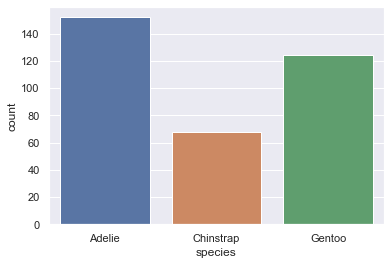

In [5]:
sns.countplot(data=data, x="species")

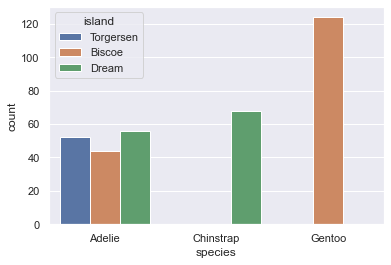

In [6]:
sns.countplot(data=data, x="species", hue="island")

Es necesario recordar que nuestra variable objetivo es la columna **species**. A partir del gráfico es posible identificar como la cantidad de registros se encuentra desbalanceada.

* ¿Es apropiado trabajar con un conjunto de datos desbalanceado en modelos de clasificación?

Es evidente que los datos no están balanceados, sin embargo, dado que no son tantos registros, vamos a continuar con el desarrollo del ejercicio.

**NOTA:** Para conocer las desventajas de los datos desequilibrados y más formas de manejarlos, lea [este](https://elitedatascience.com/imbalanced-classes) artículo.

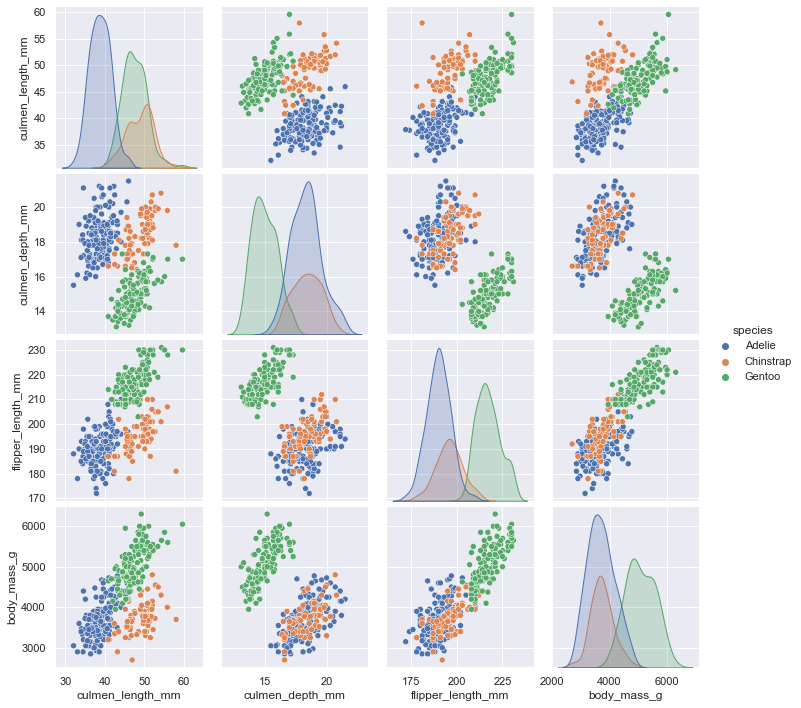

In [7]:
sns.pairplot(data=data, hue='species')

En las diagonales puedes observar la distribución de los datos para cada una de las clases (columna **species**). Las nubes de puntos muestran una comparación entre los atributos numéricos y puede ver que tan bien identificadas están las clases.

* ¿Qué característica puedes notar en las distribuciones?
* ¿Cuales pares de columnas muestran una mejor agrupación de las clases?

De la gráfica podemos concluir que los siguientes pares de columnas separan bien las 3 especies:
* culmen_length_mm vs culmen_depth_mm
* culmen_length_mm vs flipper_length_mm
* culmen_length_mm frente a body_mass_g

### Distribución de los datos

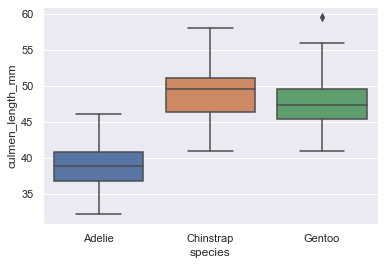

In [8]:
sns.boxplot(data=data, x="species", y="culmen_length_mm")

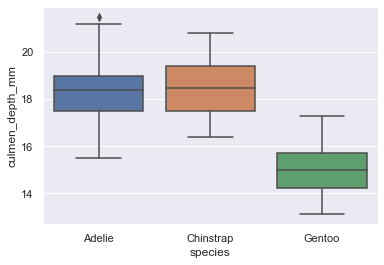

In [9]:
sns.boxplot(data=data, x="species", y="culmen_depth_mm")

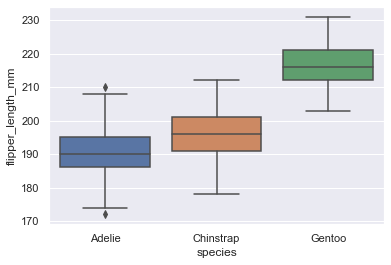

In [10]:
sns.boxplot(data=data, x="species", y="flipper_length_mm")

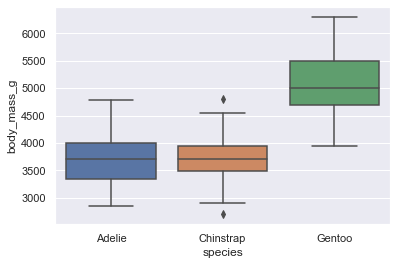

In [11]:
sns.boxplot(data=data, x="species", y="body_mass_g")

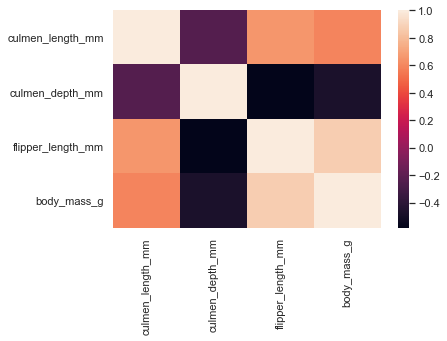

In [12]:
sns.heatmap(data.corr(method = 'pearson'))

[¿Correlaciones falsas?](http://www.tylervigen.com/spurious-correlations)

In [13]:
data.groupby(["species", "sex"]).mean()

culmen_length_mm  culmen_depth_mm  flipper_length_mm  \
species   sex                                                            
Adelie    FEMALE         37.257534        17.621918         187.794521   
          MALE           40.390411        19.072603         192.410959   
Chinstrap FEMALE         46.573529        17.588235         191.735294   
          MALE           51.094118        19.252941         199.911765   
Gentoo    .              44.500000        15.700000         217.000000   
          FEMALE         45.563793        14.237931         212.706897   
          MALE           49.473770        15.718033         221.540984   

                  body_mass_g  
species   sex                  
Adelie    FEMALE  3368.835616  
          MALE    4043.493151  
Chinstrap FEMALE  3527.205882  
          MALE    3938.970588  
Gentoo    .       4875.000000  
          FEMALE  4679.741379  
          MALE    5484.836066

En los reportes anteriores puede verse la distribución de las variables numéricas (medidas anatómicas) con respecto a la especie, al igual que una matriz de correlaciones de dichas variables. Se calcula una tabla de las medidas por especie y género de los pinguinos utilizando la media.

* ¿Que se puede intuir a partir de los reportes de distribución de los datos?

## Limpieza de los datos

### Tratamiento de datos faltantes

In [14]:
data.isnull().sum()*100/len(data)

species              0.000000
island               0.000000
culmen_length_mm     0.581395
culmen_depth_mm      0.581395
flipper_length_mm    0.581395
body_mass_g          0.581395
sex                  2.906977
dtype: float64

La proporción de datos faltantes es muy pequeño. Podemos imputar los datos faltantes utilizando La **mediana** en las características numéricas y con la **moda** en las categóricas.

**NOTA:** Los valores faltantes también se pueden completar usando funciones predefinidas como *SimpleImputer* de sklearn.

In [15]:
for column in ["culmen_length_mm", "culmen_depth_mm", "flipper_length_mm", "body_mass_g"]:
    data[column].fillna(data[column].median(), inplace=True)

data.sex.fillna(data.sex.mode()[0], inplace=True)

Validamos que no tenemos más valores nulos

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            344 non-null    object 
 1   island             344 non-null    object 
 2   culmen_length_mm   344 non-null    float64
 3   culmen_depth_mm    344 non-null    float64
 4   flipper_length_mm  344 non-null    float64
 5   body_mass_g        344 non-null    float64
 6   sex                344 non-null    object 
dtypes: float64(4), object(3)
memory usage: 18.9+ KB


### Tratamiento de datos inexactos

Notamos además que un valor de la columna *sex* para la especie *Gentoo* tiene el valor "." (punto). Buscamos el registro correspondiente e imputamos el valor verificando los valores medios según el género.

In [17]:
data[data.sex == "."]

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
336,Gentoo,Biscoe,44.5,15.7,217.0,4875.0,.


Verificando la tabla con los valores de la media para cada columna numérica, notamos que el registro anterior tiene género **FEMALE** y procedemos a imputar con este valor.

In [18]:
data.loc[336, "sex"] = "FEMALE"

Validamos que no tenemos más valores inexactos.

In [19]:
data.sex.value_counts()

MALE      178
FEMALE    166
Name: sex, dtype: int64

## Estandarización de los datos

En los procesos de modelado es importante considerar la estandarización o normalización de las características, dado que estas se pueden encontrar en diferentes formatos, escalas o unidades. Es necesario este paso para normalizar la varianza de los datos y evitar que una variable insida drasticamente en el proceso de entrenamiento. Ver documentos de referencia:
* [Preprocessing data](https://scikit-learn.org/stable/modules/preprocessing.html#standardization-or-mean-removal-and-variance-scaling)
* [Scaling importance](https://scikit-learn.org/stable/auto_examples/preprocessing/plot_scaling_importance.html#sphx-glr-auto-examples-preprocessing-plot-scaling-importance-py)

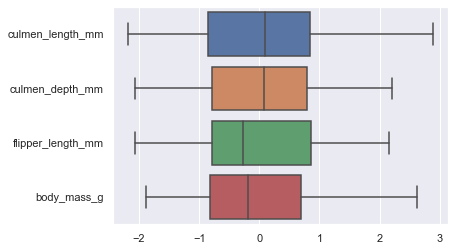

In [20]:
# Creamos un dataset aparte para la variable objetivo
data_tobe_target = data.species

# Separamos las variables categoricas del conjunto de datos
data_tobe_scaled = data.drop(["species", "island", "sex"], axis=1)

# Realizamos el proceso de estandarización con StandardScaler (opción 2: MinMaxScaler)
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_tobe_scaled)
data_scaled = pd.DataFrame(data=data_scaled, columns=data_tobe_scaled.columns)
sns.boxplot(data=data_scaled, orient="h")

## Codificación de categóricas
Los valores categóricos del conjunto de datos deben ser codificados en variables numéricas discretas o utilizando valores dummy (matriz de ceros y unos). Ver [documento](https://scikit-learn.org/stable/modules/preprocessing.html#encoding-categorical-features) de referencia.
* La variable objetivo **species** se debe codificar como un valor discreto: [Adelie, Chinstrap, Gentoo] => [0, 1, 2]
* Las demás variables categóricas se codifican con dummies, con una matriz de ceros y unos.

In [21]:
# Codificación de variable objetivo
enc_target = LabelEncoder()
data_target = pd.DataFrame(data=enc_target.fit_transform(data_tobe_target.sort_values()).ravel(), columns=['species'])
data_target.species.unique()

array([0, 1, 2])

In [22]:
cols_dummies = ['island{}'.format(i) for i in data.island.unique().tolist()] \
               + ['sex{}'.format(i) for i in data.sex.unique().tolist()]

# Codificación de las demás variables categóricas
enc_dummies = OneHotEncoder()
enc_dummies_res = enc_dummies.fit_transform(data[['island', 'sex']]).toarray()
data_dummies = pd.DataFrame(data=enc_dummies_res, columns=cols_dummies)
data_dummies.head()

,islandTorgersen,islandBiscoe,islandDream,sexMALE,sexFEMALE
0,0.0,0.0,1.0,0.0,1.0
1,0.0,0.0,1.0,1.0,0.0
2,0.0,0.0,1.0,1.0,0.0
3,0.0,0.0,1.0,0.0,1.0
4,0.0,0.0,1.0,1.0,0.0


## Consolidación conjunto de datos

In [23]:
# Unimos todos los conjuntos de datos en un solo dataframe
data_preprocessed = pd.concat([data_scaled,data_dummies,data_target],axis=1)
data_preprocessed.head()

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,islandTorgersen,islandBiscoe,islandDream,sexMALE,sexFEMALE,species
0,-0.887622,0.787289,-1.420541,-0.564625,0.0,0.0,1.0,0.0,1.0,0
1,-0.814037,0.126114,-1.063485,-0.502010,0.0,0.0,1.0,1.0,0.0,0
2,-0.666866,0.431272,-0.420786,-1.190773,0.0,0.0,1.0,1.0,0.0,0
3,0.096581,0.075255,-0.277964,-0.188936,0.0,0.0,1.0,0.0,1.0,0
4,-1.329133,1.092447,-0.563608,-0.940314,0.0,0.0,1.0,1.0,0.0,0


## Modelado de los datos

In [24]:
X = data_preprocessed.drop(['species'],axis=1)
y = data_preprocessed.species
X.shape, y.shape

((344, 9), (344,))

### Modelado de agrupamiento: *K-Means Clustering*
En este proceso usaremos la metodología **k-Means**. Es un algoritmo de aprendizaje no supervisado que agrupa datos en función de su similitud. Debemos  especificar el número de grupos (k-clusters) en los que queremos que se agrupen los datos, para este caso probaremos con un conjunto de **1 hasta 9** clusters y pretendemos validar que cantidad de clusters divide mejor el conjunto de datos. Tengamos en cuenta que la variable objetivo **species** divide los datos en tres grupos y el proposito es verificar esta situación con fines de aprendizaje.

In [25]:
range_values = range(1,10)
sum_squares = []
silhouette_coefs = []

for i in range_values:
    kmeans = KMeans(i)
    kmeans.fit(X)
    sum_squares.append(kmeans.inertia_)
    labels = kmeans.labels_
    if i > 1: silhouette_coefs.append(silhouette_score(X, labels, metric='euclidean'))
    else: silhouette_coefs.append(0)

Text(0, 0.5, 'Suma de cuadrados del cluster')

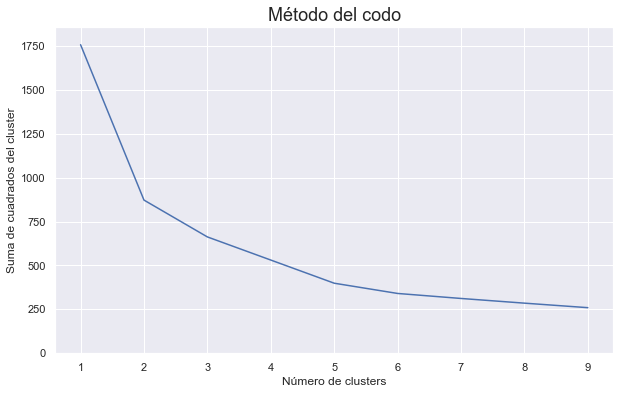

In [26]:
plt.figure(figsize=(10,6))
plt.plot(range_values, sum_squares)
plt.ylim([0,max(sum_squares)+100])
plt.title('Método del codo',{'fontsize':18})
plt.xlabel('Número de clusters')
plt.ylabel('Suma de cuadrados del cluster')

El [método del codo](https://jarroba.com/seleccion-del-numero-optimo-clusters/) es la técnica más utilizada para seleccionar la cantidad de clusters en un agrupamiento. Este método utiliza los valores de la inercia obtenidos tras aplicar el k-Means a diferentes número de clusters (desde 1 a n clusters), siendo la inercia la suma de las distancias al cuadrado de cada elemento del cluster a su centroide.
* ¿Cual consideras que es la cantidad de clusters correcto?

Text(0, 0.5, 'Coeficiente de silueta del cluster')

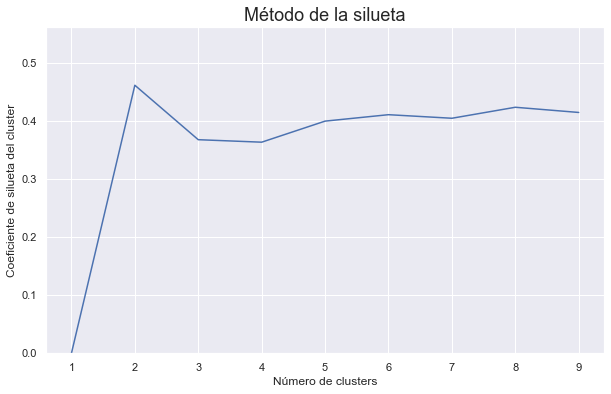

In [27]:
plt.figure(figsize=(10,6))
plt.plot(range_values, silhouette_coefs)
plt.ylim([0,max(silhouette_coefs)+0.1])
plt.title('Método de la silueta',{'fontsize':18})
plt.xlabel('Número de clusters')
plt.ylabel('Coeficiente de silueta del cluster')

El análisis de silueta se puede utilizar para estudiar la distancia de separación entre los clusters resultantes, por tanto, el [coeficiente de silueta](https://scikit-learn.org/stable/modules/clustering.html#silhouette-coefficient) es un ejemplo de tal evaluación, donde una puntuación más alta del coeficiente de silueta se relaciona con un modelo con clusters mejor definidos.
* ¿Cual consideras que es la cantidad de clusters correcto?

### Separación del conjunto de datos
Utilizaremos la función [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html?highlight=train_test_split#sklearn.model_selection.train_test_split) de scikit-learn para dividir los datos en un conjunto **entrenamiento** y **pruebas**, aplicando una separación aleatoria de los datos del **55%** y **45%**, respectivamente.

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.45, random_state=42)
print('X_train', X_train.shape, 'y_train', y_train.shape, sep=' :: ')
print('X_test', X_test.shape, 'y_test', y_test.shape, sep=' :: ')

X_train :: (189, 9) :: y_train :: (189,)
X_test :: (155, 9) :: y_test :: (155,)


### Modelado de clasificación
Realizaremos un proceso comparativo de tres modelos de clasificación diferentes: K-Nearest Neighbours, Support Vector Machine y Decision Tree. Agregaremos un [algoritmo de votación](https://scikit-learn.org/stable/modules/ensemble.html#voting-classifier) entre los tres modelos para ponderar el resultado de los clasificadores y hacer más robusto el modelo. Vamos a parametrizar de forma estática cada uno de los modelos, sin realizar optimización de hiper-parámetros ([grid-search](https://scikit-learn.org/stable/modules/grid_search.html#grid-search)) ni aplicación de técnicas para selección de características y validación cruzada ([cross-validation](https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation)).

In [29]:
# Función para realizar predicciones y generar los reportes de error
def run_model(clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    conf_mat = confusion_matrix(y_test, y_pred)
    clas_rep = classification_report(y_test, y_pred)
    return (y_pred, conf_mat, clas_rep)

### Modelado de clasificación: *K-Nearest Neighbours*

In [30]:
knn = KNeighborsClassifier(n_neighbors=1)
y_pred_knn, conf_mat_knn, clas_rep_knn = run_model(knn)
print(clas_rep_knn)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99        75
           1       0.96      1.00      0.98        26
           2       1.00      0.98      0.99        54

    accuracy                           0.99       155
   macro avg       0.98      0.99      0.99       155
weighted avg       0.99      0.99      0.99       155



### Modelado de clasificación: *Support Vector Machine*

In [31]:
svm = SVC(gamma=0.1, kernel='rbf', probability=True)
y_pred_svm, conf_mat_svm, clas_rep_svm = run_model(svm)
print(clas_rep_svm)

              precision    recall  f1-score   support

           0       0.96      1.00      0.98        75
           1       1.00      0.92      0.96        26
           2       1.00      0.98      0.99        54

    accuracy                           0.98       155
   macro avg       0.99      0.97      0.98       155
weighted avg       0.98      0.98      0.98       155



### Modelado de clasificación: *Decision Tree*

In [32]:
tree = DecisionTreeClassifier(max_depth=4)
y_pred_tree, conf_mat_tree, clas_rep_tree = run_model(tree)
print(clas_rep_tree)

              precision    recall  f1-score   support

           0       0.95      1.00      0.97        75
           1       1.00      0.92      0.96        26
           2       1.00      0.96      0.98        54

    accuracy                           0.97       155
   macro avg       0.98      0.96      0.97       155
weighted avg       0.98      0.97      0.97       155



### Modelado de clasificación: *Voting Classifier*

In [33]:
vot = VotingClassifier(estimators=[('knn', knn), ('svm', svm), ('dtree', tree)], voting='soft', weights=[1, 1, 1])
y_pred_vot, conf_mat_vot, clas_rep_vot = run_model(vot)
print(clas_rep_vot)

              precision    recall  f1-score   support

           0       0.97      1.00      0.99        75
           1       1.00      0.96      0.98        26
           2       1.00      0.98      0.99        54

    accuracy                           0.99       155
   macro avg       0.99      0.98      0.99       155
weighted avg       0.99      0.99      0.99       155



### Selección del mejor modelo

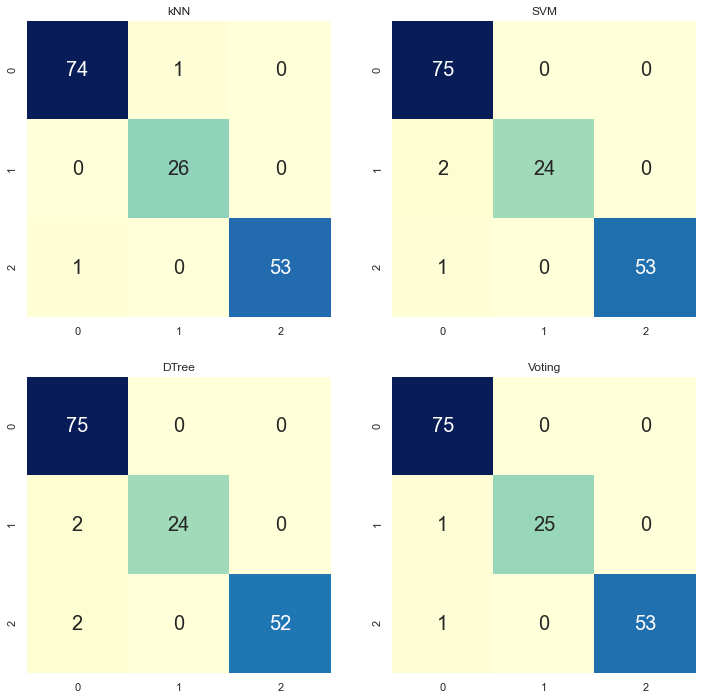

In [34]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12,12))
ax1.set_title("kNN")
sns.heatmap(conf_mat_knn, annot=True, cmap="YlGnBu", fmt="d", cbar=False, ax=ax1, annot_kws={"size": 20})
ax2.set_title("SVM")
sns.heatmap(conf_mat_svm, annot=True, cmap="YlGnBu", fmt="d", cbar=False, ax=ax2, annot_kws={"size": 20})
ax3.set_title("DTree")
sns.heatmap(conf_mat_tree, annot=True, cmap="YlGnBu", fmt="d", cbar=False, ax=ax3, annot_kws={"size": 20})
ax4.set_title("Voting")
sns.heatmap(conf_mat_vot, annot=True, cmap="YlGnBu", fmt="d", cbar=False, ax=ax4, annot_kws={"size": 20})

#### ¿Cual consideras que es el mejor modelo?